# Made with ML

- https://github.com/GokuMohandas/Made-With-ML/blob/main/notebooks/madewithml.ipynb
- https://madewithml.com/

In [1]:
# import os
# import sys
# import time
# import numpy as np
# import pandas as pd
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# import seaborn as sns
# from scipy import stats
# import warnings; warnings.filterwarnings('ignore')
# #plt.style.use('ggplot')
# plt.style.use('seaborn-whitegrid')
# %matplotlib inline

# 3. Model
## 3.1 Distributed training

### Intuition

이제 데이터가 준비되었으므로 목표에 맞게 최적화하기 위한 모델 훈련을 시작할 수 있습니다.  
가능한 가장 단순한 기준선에서 시작하여 천천히 모델에 복잡성을 추가하는 것이 이상적입니다:

1. 무작위(확률) 모델로 시작합니다.
- 클래스가 4개이므로 무작위 모델이 25% 정도는 맞을 것으로 예상할 수 있지만, 모든 클래스의 개수가 같지는 않다는 점을 기억하세요.

2. if-else 문, 정규식 등을 사용하여 규칙 기반 접근 방식을 개발합니다.
- 각 클래스에 대한 공통 단어 목록을 작성하고 입력된 단어가 목록에 있는 단어와 일치하면 해당 클래스를 예측할 수 있습니다.

3. 제한 사항을 해결하고 표현과 모델 아키텍처에 동기를 부여하여 복잡성을 서서히 추가하세요.
- 간단한 용어 빈도(TF-IDF) 모드로 시작한 다음 CNN, RNN, 트랜스포머 등을 사용한 임베딩으로 이동할 수 있습니다.

4. 성능 기준선 간의 트레이드오프(성능, 지연 시간, 크기 등)를 평가합니다.
- 데이터 세트가 커지고 새로운 모델 아키텍처가 개발됨에 따라 기준선을 재검토하고 반복합니다.
복잡한 모델을 개발하는 3단계는 바로 건너뛰겠습니다. 이 작업에는 구조화되지 않은 데이터가 포함되며 규칙 기반 시스템은 이에 적합하지 않기 때문입니다. 그리고 NLP 작업을 위한 입증된 모델 아키텍처로 대규모 언어 모델(LLM)의 채택이 증가함에 따라 데이터 세트에 대해 사전 학습된 LLM을 미세 조정할 것입니다.

Iterate on the data   

고정된 데이터 집합을 사용하고 모델을 반복하는 대신, 모델을 일정하게 유지하고 데이터 집합을 반복할 수 있습니다.  
이는 데이터 세트의 품질을 개선하는 데 유용합니다.

- 데이터 샘플 제거 또는 수정(오탐 및 미탐)
- 기능 준비 및 변환
- 클래스 확장 또는 통합
- 보조 데이터 세트 통합
- 부스트할 고유 슬라이스 식별

### Distributed training

데이터(비정형)와 모델 크기(예: LLM)가 급격히 증가함에 따라 단일 머신에서 모델을 학습시키는 것이 점점 더 어려워지고 있습니다. 합리적인 시간 내에 모델을 학습시키려면 여러 머신에 학습을 분산시킬 수 있어야 합니다. 그리고 우리는 이를 손쉽게 수행할 수 있기를 원합니다:   


- 컴퓨팅 리소스(CPU, GPU 등)를 개별적으로 (그리고 힘들게) 프로비저닝하여 클러스터를 설정합니다.  
- 여러 머신에 트레이닝을 분산하기 위해 복잡한 코드를 작성할 필요가 없습니다.  
- 서로 다른 분산 컴퓨팅 리소스 간의 통신 및 리소스 활용에 대한 걱정  
- 대규모 훈련 워크로드에서 발생하는 내결함성 및 복구에 대한 걱정  
 
이러한 모든 문제를 해결하기 위해 여기서는 레이 트레인을 사용하여 여러 머신에 걸쳐 확장할 수 있는 트레이닝 워크플로를 만들 것입니다. 분산 트레이닝을 위해 선택할 수 있는 옵션은 Pytorch 분산 데이터 병렬(DDP), Horovod 등 여러 가지가 있지만, 레이처럼 단일 머신 트레이닝 코드의 변경을 최소화하면서 여러 머신에 걸쳐 쉽게 확장할 수 있는 솔루션은 없습니다.


분산 트레이닝에 대한 입문서  

분산 학습에서는 학습 프로세스를 조율하는 헤드 노드가 있습니다. 반면 워커 노드는 모델을 훈련하고 결과를 헤드 노드에 전달하는 역할을 담당합니다.  
사용자 관점에서 보면, Ray는 이러한 모든 복잡성을 추상화하여 마치 단일 머신에서 트레이닝하는 것처럼 최소한의 코드 변경만으로 트레이닝 기능을 간단하게 정의할 수 있습니다.

### Generative AI

이 단원에서는 레이블이 지정된 데이터 세트를 사용하여 사전 학습된 대규모 언어 모델(LLM)을 미세 조정해 보겠습니다.  
우리가 사용할 특정 클래스의 LLM을 BERT라고 합니다.  
BERT 모델은 인코더 전용 모델이며 지도형 NLP 작업에 가장 적합한 표준입니다.  
하지만 제너레이티브 애플리케이션용으로 만들어진 (훨씬 더 큰) LLM(GPT 4, Falcon 40B, Llama 2 등)은 어떻게 작동하는지 궁금할 수 있습니다.

저희는 훈련과 미세 조정이 더 쉽기 때문에 더 작은 BERT 모델을 코스에 선택했습니다.  
하지만 더 큰 LLM을 미세 조정하는 워크플로도 매우 유사합니다.  
훨씬 더 많은 연산이 필요하지만 Ray는 이와 관련된 스케일링의 복잡성을 추상화합니다.

--- 생략----  
추후 해볼 것

### Setup

이제 라이브러러리를 정의하고 우리 모델을 설정해보자.

In [2]:
import os
import random
import torch
import torch.nn as nn
from ray.data.preprocessor import Preprocessor
from transformers import BertTokenizer
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [3]:
import numpy as np

In [4]:
# Label to index
tags = ['mlops', 'natural-language-processing', 'computer-vision', 'other']
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [5]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sguys99/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)

In [7]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [8]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [9]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

라이브러리 전체에 걸쳐 재현성을 위한 시드를 설정하는 set_seeds 함수를 정의할 것입니다(np.random.seed, random.seed, torch.manual_seed 및 torch.cuda.manual_seed).  
또한 GPU에서 워크로드를 실행할 때 결정론적 결과를 보장하기 위해 일부 토치 백엔드에 대한 동작을 설정할 것입니다.

In [10]:
def set_seeds(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [11]:
import ray

# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-12-15 08:46:47,984	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8266


In [12]:
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
# df = pd.read_csv(DATASET_LOC)
# df.head()

다음으로, 소스(CSV 파일)에서 데이터를 수집하고 이를 레이 데이터 세트로 로드하는 간단한 load_data 함수를 정의하겠습니다.

In [13]:
def load_data(num_samples = None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_suffle(seed = 1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

매우 큰 데이터 세트로 작업할 때는 코드를 빠르게 실행하고 버그 등을 반복할 수 있도록 데이터 세트의 샘플 수를 제한하는 것이 좋습니다. 
이것이 바로 load_data 함수에 num_samples 입력 인수가 있는 이유입니다(None = 제한 없음, 모든 샘플).

또한 데이터 세트를 편리하게 전처리하고 나중에 저장/로드하기 위해 사용할 사용자 정의 전처리기 클래스를 정의하겠습니다.  

전처리기를 정의할 때, 데이터 세트에 맞추는 방법을 학습하기 위한 _fit 메서드와 _fit 메서드의 구성 요소를 사용해 데이터 세트를 전처리하기 위한 _transform_{pandas|numpy} 메서드를 정의해야 합니다.  
전처리를 판다스 데이터프레임에 적용하기 위해 _transform_pandas 메서드를 정의하거나, 전처리를 NumPy 배열에 적용하기 위해 _transform_numpy 메서드를 정의할 수 있습니다.  
여기서는 전처리 함수가 데이터 배치를 Pandas 데이터 프레임으로 예상하므로 _transform_pandas 메서드를 정의하겠습니다.

In [14]:
class CustomPreprocessor(Preprocessor):
    """Custom preprocessor class."""
    def _fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    def _transform_pandas(self, batch):  # could also do _transform_numpy
        return preprocess(batch, class_to_index=self.class_to_index)

#### Model

이제 모델 아키텍처를 정의할 준비가 되었습니다. 먼저 사전 학습된 LLM을 로드한 다음 데이터 세트에서 미세 조정하는 데 필요한 구성 요소를 정의하겠습니다. 여기서 말하는 사전 학습된 LLM은 scibert라는 대규모 과학 텍스트 코퍼스에 대해 사전 학습된 트랜스포머 기반 모델입니다.

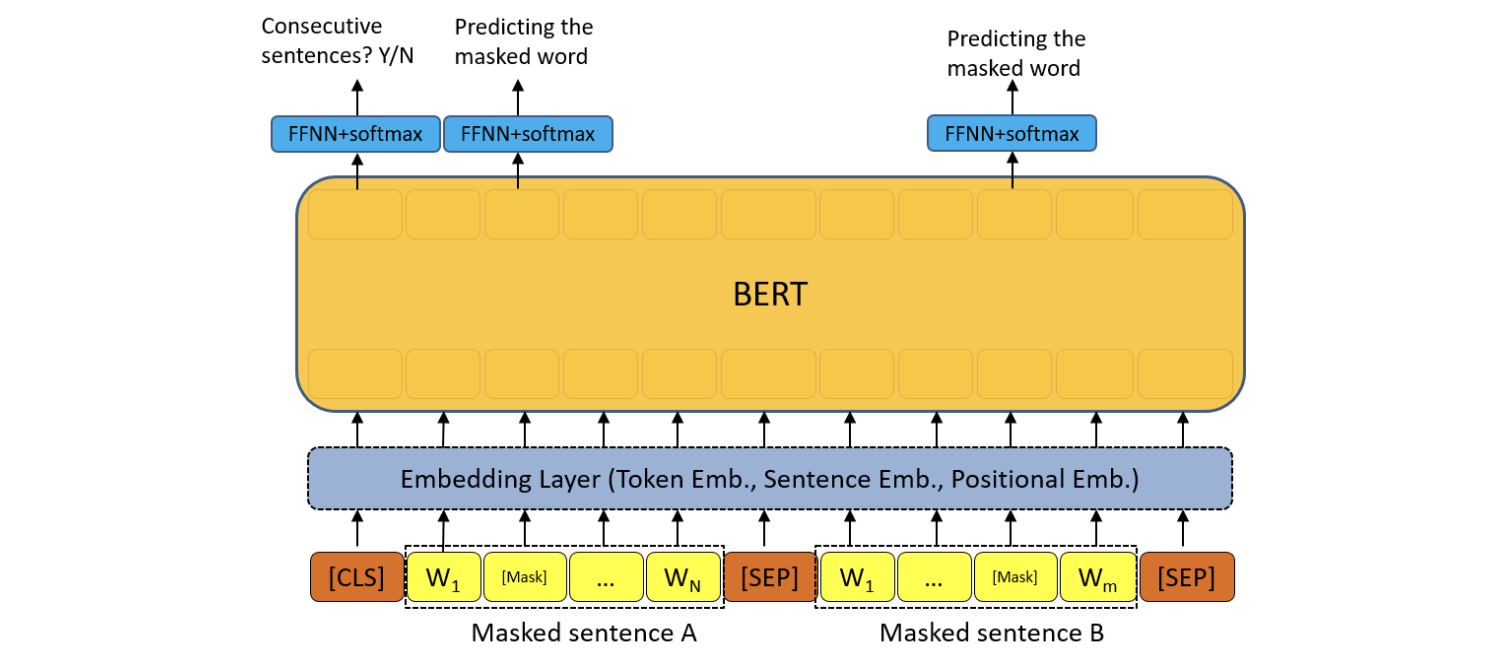

In [15]:
import torch.nn as nn
from transformers import BertModel

In [16]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
embedding_dim

768

모델이 로드되면 입력 텍스트를 토큰화하여 토치 텐서로 변환한 후 모델을 통과시켜 텍스트의 시퀀스와 풀링된 표현을 얻을 수 있습니다.

In [18]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")

In [19]:
batch

{'input_ids': array([[  102,  2268,  1904,   190, 29155,   168,  3267,  2998,   205,
          103]]), 'token_type_ids': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [20]:
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
batch

{'input_ids': tensor([[  102,  2268,  1904,   190, 29155,   168,  3267,  2998,   205,   103]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [21]:
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

이 사전 학습된 모델을 사용해 입력 텍스트의 특징을 표현하고 그 위에 특정 분류 작업을 위한 추가 레이어(선형 분류기)를 추가하겠습니다.   
간단히 말해, 사전 학습된 LLM은 토큰화된 텍스트를 처리하고 텍스트의 시퀀스(각 토큰 뒤에 하나의 표현)와 풀링된(결합된) 표현을 반환합니다. 풀링된 표현을 최종 완전 연결 계층(fc1)의 입력으로 사용하여 예측에 사용할 수 있는 num_classes(클래스 수) 크기의 벡터를 생성합니다.

In [22]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

모델 초기화

In [23]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

#### Batching

데이터 집합을 일괄적으로 반복할 수 있지만 크기가 다른 배치가 있을 수 있습니다.  
토큰화 도구가 배치에서 가장 긴 항목에 입력을 패딩했다는 점을 기억하세요(패딩="가장 긴").  
그러나 학습용 배치는 대규모 데이터 처리 배치보다 작을 것이므로 여기서의 배치에는 길이가 다른 입력이 있을 수 있습니다.  
이 문제를 해결하기 위해 사용자 정의 collate_fn을 정의하여 훈련 배치의 항목을 다시 패딩하겠습니다.